In [1]:
from ensembles import VanillaEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two estimators, comparing to a vanialla Neural Network.

All Estimators are built in tensorflow (1.4 [*]) and are based on the same parent object (ToDo: Make this more beautiful and readable). Code can be found in /estimators.

GaussianLossEstimator [1], in which $\mu$ and $\sigma^2$ are estimated directly by using a gaussian cost function $-1/2 ln [\sigma^2(x_i)] - \frac{[y-\hat{y}]^2}{2\sigma^2(x_i)} $. In practice, this means separate output nodes have been added for both mean and variance, with corrensponding final layers. To ensure positive $\sigma^2$, a softmax function is applied according to [2]. 

GaussianLearningRateEstimator, which is a GaussianLossEstimator in which the predicted $\sigma$ is used to scale the learning rate for each sample. This approach hasn't been found in a [arguable somewhat shallow] literature review. It's too early to claim novelty, but it is fun to work with!

For both models, a minimum variance is returned if the variance goes below a certain threshold to (try to) avoid numerical instabilities


No Regularisation has been added, thus quite a bit of overfitting occurs.







# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), so no distribution over parameters


# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is on-line, i.e. each sample is fed into the network on a singular basis (Stochastic gradient descent with batch size 1)

The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list)


# Problems/ToDo
Weirdly, the standard GaussianLossEstimator tends to fall into numerical instabilities (see e.g. seed #forgottowritedowntheseedandIfeelbad (1011???))

Overfitting is locally SEVERE sometimes (e.g. seed 43). Why.

Adding SOME Regularisation might be cool: The learning rate thing looks like a perfect fit for early stopping

Hyperparameters need to be tuned

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)

Learningrate scaling in GaussianLearningRateEstimator is absolutely eyeballed and not based on any evidence at all except for the fact that 'I've seeb people use square roots in combination with the standard deviation/variance'.


Implement Dropout Estimator from [3] and give it the whole routine




# Sources

[1] Nix, D. A., & Weigend, A. S. (1994, June). Estimating the mean and variance of the target probability distribution. In Neural Networks, 1994. IEEE World Congress on Computational Intelligence., 1994 IEEE International Conference On (Vol. 1, pp. 55-60). IEEE.
Chicago	
Link: http://ieeexplore.ieee.org/abstract/document/374138/


[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474

[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html


[*] BIG shoutout to https://danijar.com/structuring-your-tensorflow-models/ for helping me understand how to use Tensorflow in an object oriented manner


# Preparations

In [2]:
num_epochs = 10
num_eps = 75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}
          #'optimizer':tf.train.AdamOptimizer}


In [3]:

data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

In [4]:
#X_test[:10],X[:10]

In [5]:
#len(X), len(sorted_index),len(data['test_ind']),len(X_test)

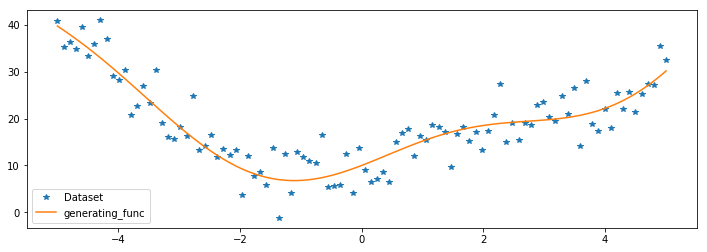

In [6]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# initialise Networks

In [7]:
from estimators import GaussianLossEstimator,GaussianLearningRateEstimator, EnsembleNetwork

gauss = GaussianLossEstimator(**params)
gauss_lr = GaussianLearningRateEstimator(**params)
vanilla = EnsembleNetwork(**params)

In [8]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)


lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

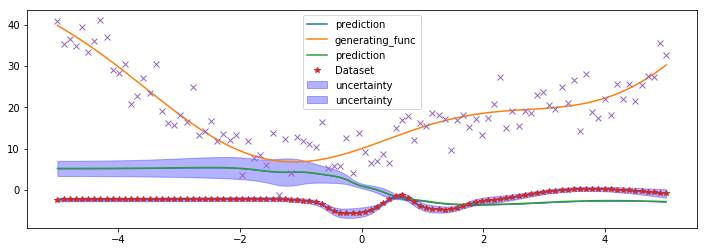

In [9]:
plot_prediction(X,
                gauss_preds,
                sorted_index,
                gauss_var,
                generating_func=generate_sinoid)
plot_prediction(X,
                lr_preds,
                sorted_index,
                lr_var)
plot_prediction(X,vanilla_preds,sorted_index)
plt.plot(X,y,'x')

In [10]:
evaluate_model(X,y,gauss_preds)

RSME is 22.714373114282253


In [11]:
evaluate_model(X,y,lr_preds)

RSME is 20.26798193618764


In [12]:
evaluate_model(X,y,vanilla_preds)

RSME is 22.714373114282253


# Training


## GaussianLossEstimator

Maye replace min_variance with 

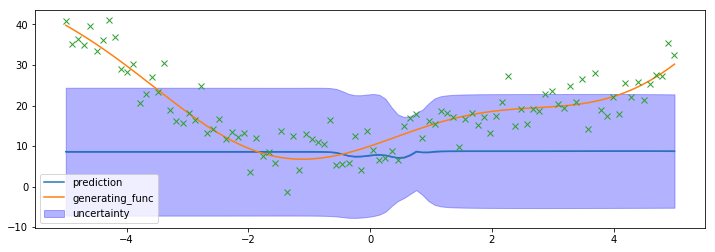

RSME is 13.596103510041397
COVERAGE PROBABILITY is 0.72
MEAN VARIANCE is 14.639887809753418
COVERAGE/MEAN_VAR is 0.0491807047537837


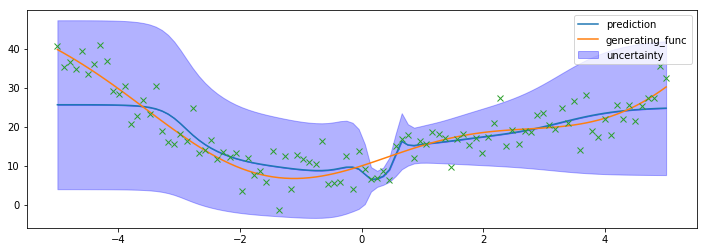

RSME is 5.198561394834368
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.319430351257324
COVERAGE/MEAN_VAR is 0.07357672018664749


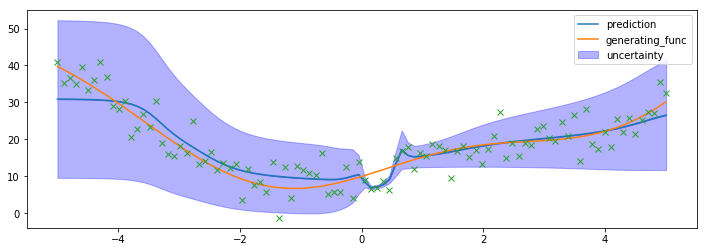

RSME is 4.2545053771490755
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 10.661001205444336
COVERAGE/MEAN_VAR is 0.08723383311551168


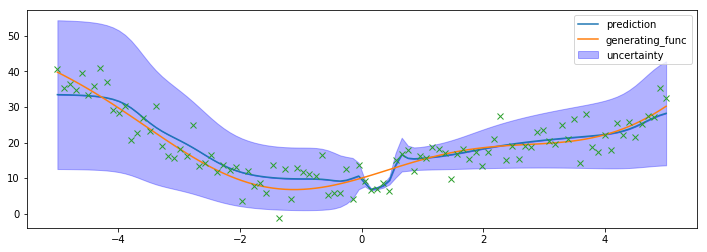

RSME is 3.9127615192748935
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 9.99500560760498
COVERAGE/MEAN_VAR is 0.09204597136994022


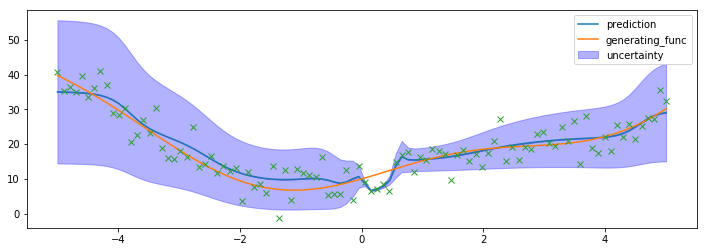

RSME is 3.7284960271999923
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 9.60367202758789
COVERAGE/MEAN_VAR is 0.09683795920231814


In [13]:
gauss_error_list = []
for i in range(num_eps):
    #gauss.train(X,y)
    errors = gauss.train_and_evaluate(X,y)
    gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss.predict(X)
        gauss_var = gauss.predict_var(X)

        #lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

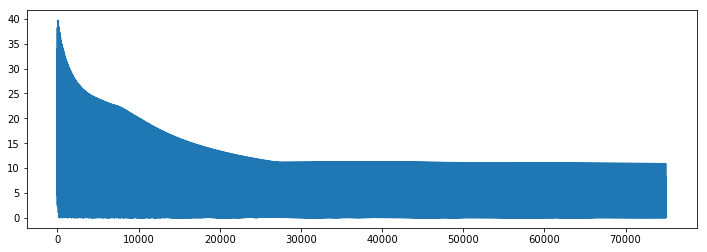

In [14]:
import numpy as np
plt.plot(np.squeeze(gauss_error_list))

## GaussianLearningRateEstimator

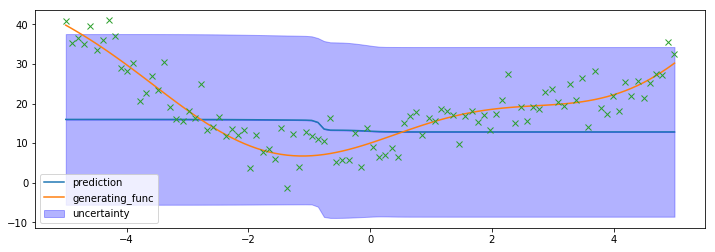

RSME is 10.119905352860235
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 21.49254608154297
COVERAGE/MEAN_VAR is 0.0446666484444304


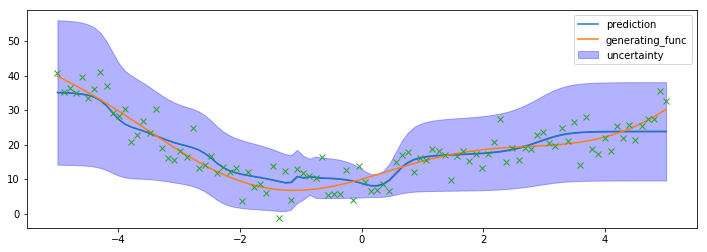

RSME is 4.033595333476787
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.502309799194336
COVERAGE/MEAN_VAR is 0.08346149745221103


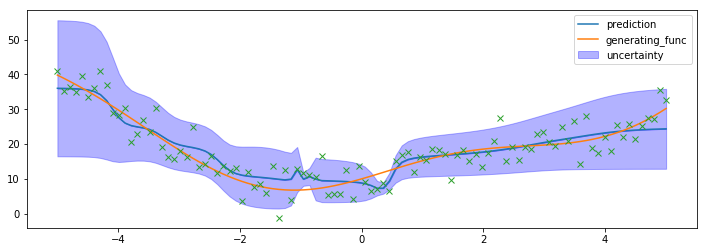

RSME is 3.872996310409252
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.618291854858398
COVERAGE/MEAN_VAR is 0.11023066008891953


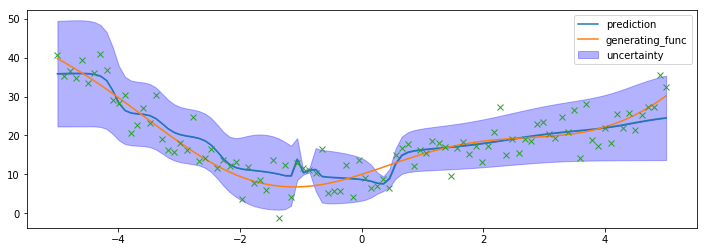

RSME is 3.8625175192584233
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 7.626452445983887
COVERAGE/MEAN_VAR is 0.12194398464908031


In [15]:
gauss_lr_error_list = []
for i in range(num_eps):
    errors = gauss_lr.train_and_evaluate(X,y)
    gauss_lr_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%20 ==0:
        gauss_preds = gauss_lr.predict(X)
        gauss_var = gauss_lr.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

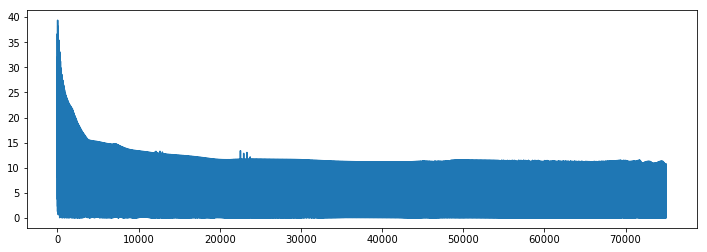

In [16]:
plt.plot(np.squeeze(gauss_lr_error_list))
#plt.xlim(0, 150)


## Vanilla Neural Network for comparisson

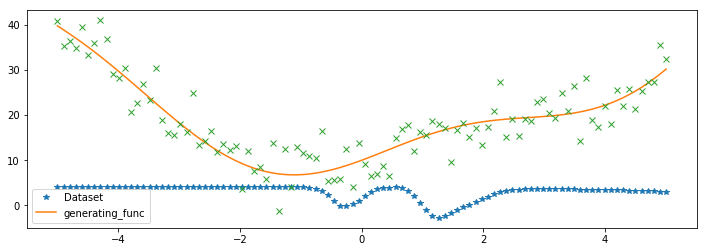

RSME is 18.102985141119575


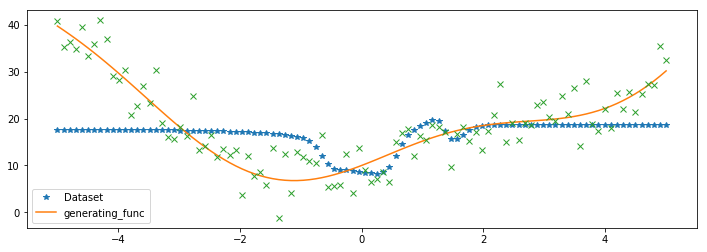

RSME is 8.302890710506523


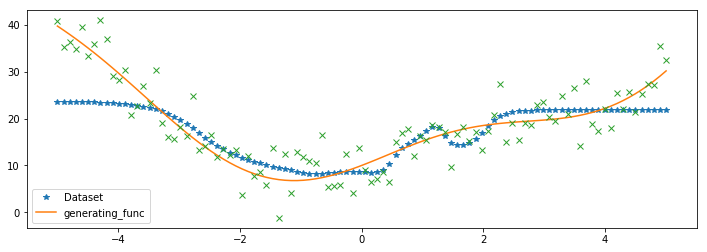

RSME is 5.822958916559945


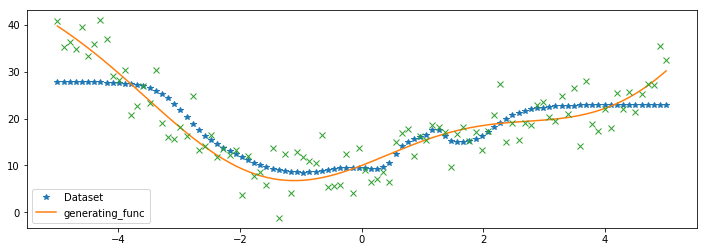

RSME is 4.96226917415461


In [17]:
vanilla_errors = []
for i in range(num_eps):
    #vanilla_errors+=vanilla.train_and_evaluate(X,y)
    #gauss_lr.train(X,y)
    vanilla.train(X,y)
    if i%20 ==0:
        #gauss_preds = vanilla.predict(X)
        #gauss_var = vanilla.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        vanilla_preds = vanilla.predict(X)
        plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds)

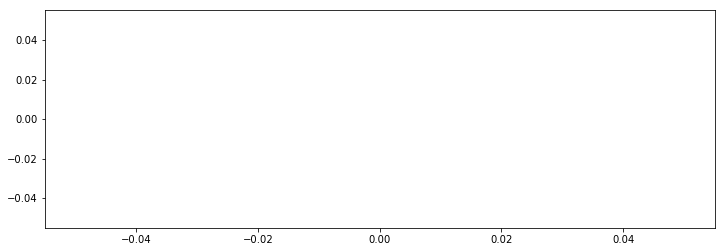

In [18]:
plt.plot(np.squeeze(vanilla_errors))

In [19]:
np.squeeze(vanilla_errors)

array([], dtype=float64)

# Old Stuff can probbly be removed only staying for security reasons

In [20]:
gauss.train(X,y)
gauss_lr.train(X,y)
vanilla.train(X,y)

In [21]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)

lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

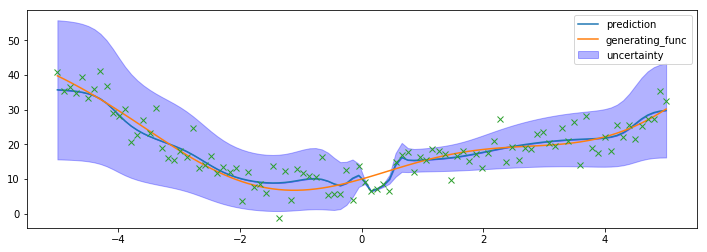

In [22]:
plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

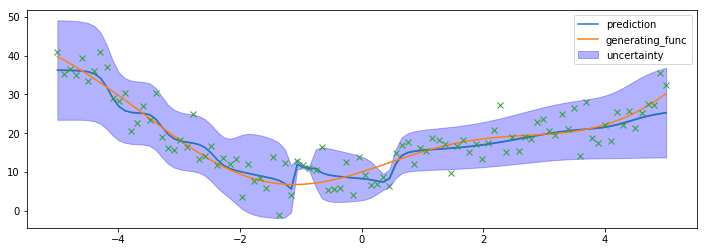

In [23]:
plot_prediction(X,lr_preds,sorted_index,lr_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

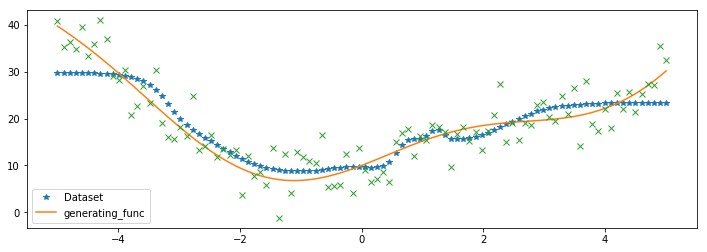

In [24]:
plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [25]:
evaluate_model(X,y,gauss_preds,var=gauss_var)

RSME is 3.582182762120477
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 9.000465393066406
COVERAGE/MEAN_VAR is 0.10332799020775463


In [26]:
evaluate_model(X,y,lr_preds,var=lr_var)

RSME is 3.65426598503637
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 7.495911121368408
COVERAGE/MEAN_VAR is 0.12673576095264236


In [27]:
evaluate_model(X,y,vanilla_preds)

RSME is 4.581442334055325
